In [1]:
#install libraries

!rm -r kdg
!git clone --branch kdf_prog https://github.com/AishwaryaSeth/kdg
!ls
!pip install kdg/.

from google.colab import drive
drive.mount('/content/gdrive')

Cloning into 'kdg'...
remote: Enumerating objects: 4616, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 4616 (delta 3), reused 4 (delta 2), pack-reused 4608
Receiving objects: 100% (4616/4616), 55.59 MiB | 26.82 MiB/s, done.
Resolving deltas: 100% (1657/1657), done.
gdrive	kdg  sample_data
Processing ./kdg
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for kdg: filename=kdg-0.0.1-py3-none-any.whl size=18293 sha256=319e95b7a8fce74637d855e22bb2e84fba51e14c77fb337fe692827cd4286820
  Stored in directory: /tmp/pip-ephem-wheel-cache-fkv8k8p2/wheels/e0/72/2b/338836d1623d7

In [2]:
# import modules
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from matplotlib.ticker import ScalarFormatter

from kdg.kdf import *
from kdg.utils import *


In [3]:
fit_kwargs = {"n_estimators": 500, "verbose": 0}
#Get initial KDF
size = 20
overlap = 0.25

In [22]:
X1, y1 = generate_spirals(750, 3, noise=0.8)
X2, y2 = generate_spirals(750, 5, noise=0.4)
# use generate_data from Tiffany's branch 
# Don't create new data to do the transfer 
# Artificially inflates the likelihoods + have more understanding about the first task 
# X1_trans, y1_trans = generate_gaussian_parity(size, cluster_std=overlap)
# X2_trans, y2_trans = generate_gaussian_parity(size, cluster_std=overlap, angle_params = np.pi/2)
X1_test, y1_test = generate_spirals(750, 3, noise=0.8)
X2_test, y2_test = generate_spirals(750, 5, noise=0.4)

transfer_kdf = kdf(kwargs = fit_kwargs)
transfer_kdf.fit(X1, y1, task_id = "3 Spirals")
transfer_kdf.fit(X2, y2, task_id = "5 Spirals")

In [23]:
xor = np.mean(transfer_kdf.predict(X1_test, "3 Spirals") == y1_test)
print(f"3 Spirals: {xor}")
rxor = np.mean(transfer_kdf.predict(X2_test, "5 Spirals") == y2_test)
print(f"5 Spirals: {rxor}")

3 Spirals: 0.7546666666666667
5 Spirals: 0.7386666666666667


In [24]:
transfer_kdf.forward_transfer(X1, y1, "3 Spirals")
xor_transfer = np.mean(transfer_kdf.predict(X1_test, "3 Spirals") == y1_test)
print(f"3 Spirals: {xor_transfer}")

transfer_kdf.forward_transfer(X2, y2, "5 Spirals")
rxor_transfer = np.mean(transfer_kdf.predict(X2_test, "5 Spirals") == y2_test)
print(f"5 Spirals: {rxor_transfer}")

3 Spirals: 0.7546666666666667
5 Spirals: 0.74


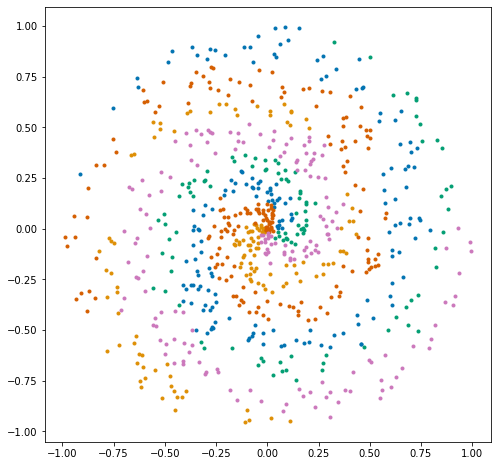

In [18]:
plot_2dsim(X2_test, transfer_kdf.predict(X2_test, "5 Spirals"))

In [8]:

def experiment(
    n_task1,
    n_task2,
    n_test=1000,
    task1_spirals=3,
    task2_spirals=5,
    task1_noise=0.8,
    task2_noise=0.4,
    overlap = 0.25,
    task1_id="Task1",
    task2_id="Task2",
    dense_layer_nodes = 5,
    random_state=None,
):

    """
    A function to do KDF-FT experiment between two tasks
    where the task data is generated using Gaussian parity.
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    n_task2 : int
        Total number of train dsample for task 2
    n_test : int, optional (default=1000)
        Number of test sample for each task.
    task1_angle : float, optional (default=0)
        Angle in radian for task 1.
    task2_angle : float, optional (default=numpy.pi/4)
        Angle in radian for task 2.
    task1_id : str, optional (default="Task1")
        Name of Task 1
    task2_angle : float, optional (default="Task2")
        Name of Task 2
    dense_layer_nodes : int, optional (default=5)
        Controls size of neural network
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive KDF error task1,
        naive KDF task2.
    """

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    # source data
    X_task1, y_task1 = generate_spirals(n_task1, task1_spirals, task1_noise)
    test_task1, test_label_task1 = generate_spirals(
        n_test, task1_spirals, task1_noise
    )

    # target data
    X_task2, y_task2 = generate_spirals(n_task2, task2_spirals, task2_noise)
    test_task2, test_label_task2 = generate_spirals(
        n_test, task2_spirals, task2_noise
    )
    
    #Create KDFs
    kdf_task1 = kdf(kwargs = fit_kwargs)
    kdf_task1.fit(X_task1, y_task1, task_id=task1_id)

    if n_task2 == 0:
        single_task1 = kdf_task1.predict(test_task1, task_id=task1_id)
        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(single_task1 == test_label_task1)
        errors[2] = 0.5
        errors[3] = 0.5
        errors[4] = 1 - np.mean(single_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        kdf_task2 = kdf(kwargs = fit_kwargs)
        kdf_task2.fit(X_task2, y_task2, task_id=task2_id)

        # kdf1 & kdf2 are combined into one dataset & we 
        # check what the Bayes' estimate would be 
        # labels are not changed 
        # Obv, always quite bad 
        naive_X = np.concatenate((X_task1, X_task2), axis=0)
        naive_y = np.concatenate((y_task1, y_task2), axis=0)
        kdf_naive = kdf(kwargs = fit_kwargs)
        kdf_naive.fit(naive_X, naive_y, task_id="Naive")

        kdf_prog = kdf(kwargs = fit_kwargs)
        kdf_prog.fit(X_task1, y_task1, task_id=task1_id)
        kdf_prog.fit(X_task2, y_task2, task_id=task2_id)
        # Replace this with generated data
        # kdf.generated_data with the task_id & task sizes
        # Overfitting when we do the transfer using the original data
        # Generate: Based on polytope size, select polytopes 
        # Don't know the data after its done learning 
        # Only knows what posteriors are there 
        # So we generate data from the posteriors that it has 

        # GENERATE HERE  
        X_trans1, y_trans1 = kdf_prog.generate_data(n_task1, task1_id, force_equal_priors = False)
        X_trans2, y_trans2 = kdf_prog.generate_data(n_task2, task2_id, force_equal_priors = False)

        kdf_prog.forward_transfer(X_trans1, y_trans1, task_id=task1_id)
        kdf_prog.forward_transfer(X_trans2, y_trans2, task_id=task2_id)
        
        # Predictions for all 
        single_task1 = kdf_task1.predict(test_task1, task_id=task1_id)
        single_task2 = kdf_task2.predict(test_task2, task_id=task2_id)
        naive_task1 = kdf_naive.predict(test_task1, task_id="Naive")
        naive_task2 = kdf_naive.predict(test_task2, task_id="Naive")
        prog_task1 = kdf_prog.predict(test_task1, task_id=task1_id)
        prog_task2 = kdf_prog.predict(test_task2, task_id=task2_id)

        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(prog_task1 == test_label_task1)
        errors[2] = 1 - np.mean(single_task2 == test_label_task2)
        errors[3] = 1 - np.mean(prog_task2 == test_label_task2)
        errors[4] = 1 - np.mean(naive_task1 == test_label_task1)
        errors[5] = 1 - np.mean(naive_task2 == test_label_task2)

    return errors

def plot_error_and_eff(n1s, n2s, mean_error, mean_te, TASK1, TASK2):
    """
    A function that plots the generalization error and
    transfer efficiency for the xor-nxor-rxor experiment
    Parameters
    ----------
    n1s : range(int)
        Array of sample sizes tested for the first learner.
    n2s : range(int)
        Array of sample sizes tested for the second learner.
    mean_error : np.array
        Array of generalization errors.
    mean_te : np.array
        Array of transfer efficiencies.
    task1 : str
        String of the name of the first task.
    task2 : str
        String of the name of the second task.
    """

    ns = np.concatenate((n1s, n2s + n1s[-1]))
    ls = ["-", "--"]

    ################################
    # Plots of Generalization Error
    ################################
    algorithms = [f"Single Task {TASK1}",
                  f"Transfer {TASK1}",
                  f"Single Task {TASK2}",
                  f"Transfer {TASK2}",
                  f"Naive {TASK1}",
                  f"Naive {TASK2}"]

    fontsize = 30
    labelsize = 28

    colors = sns.color_palette("Set1", n_colors=2)

    fig = plt.figure(constrained_layout=True, figsize=(21, 14))
    gs = fig.add_gridspec(14, 21)
    ax1 = fig.add_subplot(gs[7:, :6])
    ax1.plot(
        ns,
        mean_error[1],
        label=algorithms[1],
        c=colors[0],
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )
    ax1.plot(
        ns,
        mean_error[0],
        label=algorithms[0],
        c="g",
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK1), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=20, frameon=False)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_yticks([0.1, 0.3, 0.5])
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")
    ax1.set_title(f"{TASK1}", fontsize=30)

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ##############

    ax1 = fig.add_subplot(gs[7:, 7:13])

    ax1.plot(
        ns[len(n1s) :],
        mean_error[3, len(n1s) :],
        label=algorithms[3],
        c=colors[0],
        lw=3,
    )
    ax1.plot(
        ns[len(n1s) :], mean_error[2, len(n1s) :], label=algorithms[2], c="g", lw=3
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK2), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=20, frameon=False)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_yticks([0.1, 0.5, 0.9])
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ax1.set_title(f"{TASK2}", fontsize=30)

    ################################
    # Plots of Transfer Efficiency
    ################################

    algorithms = ["KDF BTE", "KDF FTE", "Naive BTE", "Naive FTE"]

    ax1 = fig.add_subplot(gs[7:, 14:])

    ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[1, len(n1s) :],
        label=algorithms[1],
        c=colors[0],
        ls=ls[1],
        lw=3,
    )
    ax1.plot(ns, mean_te[2], label=algorithms[2], c="g", ls=ls[0], lw=3)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[3, len(n1s) :],
        label=algorithms[3],
        c="g",
        ls=ls[1],
        lw=3,
    )

    ax1.set_ylabel(
        "log Forward/Backward \n Transfer Efficiency (FTE/BTE)", fontsize=fontsize
    )
    ax1.legend(loc="lower left", fontsize=20, frameon=False)
    ax1.set_yticks([0.2, 0.6, 1, 1.2])
    ax1.set_ylim(0.2, 1.2)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    log_lbl = np.round(np.log([0.2, 0.6, 1, 1.2]), 2)
    labels = [item.get_text() for item in ax1.get_yticklabels()]

    for ii, _ in enumerate(labels):
        labels[ii] = str(log_lbl[ii])

    ax1.set_yticklabels(labels)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)
    ax1.hlines(1, 50, 200, colors="gray", linestyles="dashed", linewidth=1.5)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    colors = sns.color_palette("Dark2", n_colors=2)

    X, Y = generate_spirals(n1s[-1], n_class = 3, noise = 0.8)
    Z, W = generate_spirals(n2s[-1], n_class = 5, noise = 0.4)

    ax = fig.add_subplot(gs[:6, 4:10])
    clr = [colors[i] for i in Y]
    ax.scatter(X[:, 0], X[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("3 Spirals", fontsize=30)

    ax.axis("off")

    colors = sns.color_palette("Dark2", n_colors=2)

    ax = fig.add_subplot(gs[:6, 11:16])
    clr = [colors[i] for i in W]
    ax.scatter(Z[:, 0], Z[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("5 Spirals", fontsize=30)
    ax.axis("off")

In [9]:
mc_rep = 100
n_test = 1000
n_spiral3 = (100 * np.arange(0.5, 7.25, step=0.25)).astype(int)
n_spiral5 = (100 * np.arange(0.5, 7.50, step=0.25)).astype(int)

In [10]:
from math import log2, ceil

In [11]:
mean_error = np.zeros((6, len(n_spiral3) + len(n_spiral5)))
std_error = np.zeros((6, len(n_spiral3) + len(n_spiral5)))

mean_te = np.zeros((4, len(n_spiral3) + len(n_spiral5)))
std_te = np.zeros((4, len(n_spiral3) + len(n_spiral5)))

for i, n1 in enumerate(n_spiral3):
    print("starting to compute %s for 3 spirals\n" % n1)
    error = np.array([experiment(n1, 0) for _ in range(mc_rep)])
    mean_error[:, i] = np.mean(error, axis=0)
    std_error[:, i] = np.std(error, ddof=1, axis=0)
    mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
    mean_te[1, i] = np.mean(error[:, 2]) / np.mean(error[:, 3])
    mean_te[2, i] = np.mean(error[:, 0]) / np.mean(error[:, 4])
    mean_te[3, i] = np.mean(error[:, 2]) / np.mean(error[:, 5])

    if n1 == n_spiral3[-1]:
        for j, n2 in enumerate(n_spiral5):
            print("starting to compute %s for 5 spirals\n" % n2)

            error = np.array([experiment(n1, n2) for _ in range(mc_rep)])
            
            mean_error[:, i + j + 1] = np.mean(error, axis=0)
            std_error[:, i + j + 1] = np.std(error, ddof=1, axis=0)
            mean_te[0, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 1])
            mean_te[1, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 3])
            mean_te[2, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 4])
            mean_te[3, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 5])

starting to compute 50 for 3 spirals

starting to compute 75 for 3 spirals

starting to compute 100 for 3 spirals

starting to compute 125 for 3 spirals

starting to compute 150 for 3 spirals

starting to compute 175 for 3 spirals

starting to compute 200 for 3 spirals

starting to compute 225 for 3 spirals

starting to compute 250 for 3 spirals

starting to compute 275 for 3 spirals

starting to compute 300 for 3 spirals

starting to compute 325 for 3 spirals

starting to compute 350 for 3 spirals

starting to compute 375 for 3 spirals

starting to compute 400 for 3 spirals

starting to compute 425 for 3 spirals

starting to compute 450 for 3 spirals

starting to compute 475 for 3 spirals

starting to compute 500 for 3 spirals

starting to compute 525 for 3 spirals

starting to compute 550 for 3 spirals

starting to compute 575 for 3 spirals

starting to compute 600 for 3 spirals

starting to compute 625 for 3 spirals

starting to compute 650 for 3 spirals

starting to compute 675 for

ValueError: ignored

In [ ]:
def run(mc_rep, n_test, n_nodes, n_task1, n_task2,
        mean_error, std_error, mean_te, std_te, overlap):
    for i, n1 in enumerate(n_task1):
        print('starting to compute %s 3 Spirals\n'%n1)
        error = np.array([experiment(n1, 0) for _ in range(mc_rep)])
        mean_error[:, i] = np.mean(error, axis=0)
        std_error[:, i] = np.std(error, ddof=1, axis=0)
        mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        mean_te[1, i] = np.mean(error[:, 2]) / np.mean(error[:, 3])
        mean_te[2, i] = np.mean(error[:, 0]) / np.mean(error[:, 4])
        mean_te[3, i] = np.mean(error[:, 2]) / np.mean(error[:, 5])

        if n1 == n_task1[-1]:
            for j, n2 in enumerate(n_task2):
                print('starting to compute %s 5 spirals\n'%n2)
                error = np.array([experiment(n1, n2) for _ in range(mc_rep)])

                mean_error[:, i + j + 1] = np.mean(error, axis=0)
                std_error[:, i + j + 1] = np.std(error, ddof=1, axis=0)
                mean_te[0, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 1])
                mean_te[1, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 3])
                mean_te[2, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 4])
                mean_te[3, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 5])

    return mean_error, std_error, mean_te, std_te



In [ ]:
# define hyperparameters:
mc_rep = 20
n_nodes = 5
n_test = 1000
overlap = 0.25
n_xor = np.arange(10, 101, step=10).astype(int)
n_xnor = np.arange(10, 101, step=10).astype(int)

# running the experiment:

# create empty arrays for storing results
mean_error = np.zeros((6, len(n_xor) + len(n_xnor)))
std_error = np.zeros((6, len(n_xor) + len(n_xnor)))
mean_te = np.zeros((4, len(n_xor) + len(n_xnor)))
std_te = np.zeros((4, len(n_xor) + len(n_xnor)))

# run the experiment
mean_error, std_error, mean_te, std_te = run(
    mc_rep, n_test, n_nodes, n_xor, n_xnor,
    mean_error, std_error, mean_te, std_te, overlap
)

In [ ]:
# plot data
%matplotlib inline
plot_error_and_eff(n_xor, n_xnor, mean_error, mean_te, "3 Spirals", "5 Spirals")